# Assignment 3
**CS283 Computer Vision, Harvard University, Fall 2019**

**Due Wednesday, Oct. 2, at 5:00pm**

Name: Natalia Pacheco-Tallaj

---

This problem set reinforces your understanding of camera matrices and binocular geometry. As usual, the assignment will be submitted electronically and formatted according to the guidelines. Notice the usual *Hints and Information* section at the bottom.

As usual, the input image files that are required to complete this assignment can be found in the <tt>pset3.zip</tt> archive that accompanies this notebook on the course website. Be sure to upload this ZIP archive tp JupterHub before running the notebook's first cell (which unpacks the archive into a <tt>./pset3</tt> folder).

Remember that the online submission system closes *exactly* at the stated deadline. If you find yourself in the uncomfortable position of working very close to the deadline, we advise that you upload early and often.

In [1]:
# Run this cell (only once) to install the unzip command
! sudo apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following packages were automatically installed and are no longer required:
  libpython3.6-dev linux-aws-headers-4.15.0-1040 linux-aws-headers-4.15.0-1044
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 136 not upgraded.


In [2]:
# Extract required pset folders (make sure you ran the first cell first)
! unzip pset3.zip

Archive:  pset3.zip
  inflating: data/corners.pickle     
  inflating: data/calib_left.bmp     
  inflating: data/calib_right.bmp    
  inflating: data/kleenex_left.bmp   
  inflating: data/kleenex_right.bmp  
  inflating: img/box.png             


In [4]:
# Import other required libraries here
import cv2           # OpenCV
import numpy as np   # numpy
import scipy.interpolate
import pickle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Use this line to make matplotlib plot notebook style (only need to call it once when importing matplotlib)
%matplotlib notebook

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

## Question 1 (10 points)
$\def\vO{{\bf O}}
\def\vP{{\bf P}}
\def\vp{{\bf p}}
\def\vx{{\bf x}}
\def\vt{{\bf t}}
\def\vl{{\bf l}}
\def\vm{{\bf m}}
\def\vX{{\bf X}}
\def\mS{{\bf S}}
\def\mT{{\bf T}}
\def\mH{{\bf H}}
\def\mA{{\bf A}}
\def\mM{{\bf M}}
\def\mP{{\bf P}}
\def\tx{{\tilde{\bf x}}}
\def\ta{{\tilde{\bf a}}}
\def\tb{{\tilde{\bf b}}}
\def\tc{{\tilde{\bf c}}}
\def\hn{{\bf \hat{n}}}
\def\hv{{\bf \hat{v}}}
\def\hh{{\bf \hat{h}}}
\def\vh{{\bf h}}
\def\vs{{\bf s}}
\def\hs{{\bf \hat{s}}}$

In class we saw that a camera matrix satisfies the equation $\vx_i=\mP\vX_i$, and HZ 7.1 shows that six 3D-2D matches $\vX\leftrightarrow\vx$ are sufficient to recover $\mP$ using a linear (non-iterative) algorithm.

**a.** Create and describe specialized linear algorithms for computing the camera matrix $\mP$ in the special cases when: i) the camera location (but not orientation) is known, and ii) the camera location and complete orientation are known.

### Answer:
**Part i)** 
Knowing the camera center $\tilde{C}$ means we have $3$ degrees of freedom less to worry about. Now we have $11-3 = 8$ degrees of freedom which means we need $4$ point correspondences to determine the camera matrix. We know that our camera matrix looks like 
$$P = KR [I|-\tilde{C}] $$
with our known $\tilde{C}$. Since we know the center, we can apply $[I|-\tilde{C}]$ to the collection $\{\textbf{X}_i\}$ of world points to get a collection $\{\textbf{X}_i'\}$ of points, and now we've reduced the problem to computing the invertible $3\times 3$ marix $KR$ using the point correspondences $\textbf{X}_i'\leftrightarrow \vx$. 

Now we should find a transformation $T$ to normalize the $\vx_i$ and $U$ to normalize the $\vX_i'$ so that they are centered at their centroid and $T\vx_i$ have average distance $\sqrt{2}$ from the centroid and $U\vX_i'$ have average distance $\sqrt{3}$ from the centroid. From now on assume $\vx_i$ and $\vX'_i$ denote the normalized points. 

Now, for computing a $3\times 3$ invertible matrix we can just use the normal DLT algorithm from last week. We've already performed the normalization step, so now we build, for each point correspondence (we should have at least $4$ such correspondences) the matrix 
$$A_i = \begin{pmatrix}
    \textbf{0}^T & -w_i\vX_i'^T & y_i\vX_i'^T\\
    w_i\vX_i'^T & \textbf{0}^T & -x_i\vX_i'^T
\end{pmatrix}$$
where $\vx_i = (x_i, y_i, w_i)$ in homogeneous coordinates. Then stack all of the $A_i$'s above each other to form $A$, now we want to solve the equation
$$\textbf{A}\textbf{b}  = 0$$
Find the SVD of $A$: $A = UDV^T$, then set $\textbf{b}$ to be the last column of $V$. Turn the $9$-vector $b$ into a matrix $B$ by letting the first $3$ entries be the first row, the second three entries the second row, and so on, the usual way. Then we de-normalize: set
$$KR = T^{-1}BU $$
If we wanted to find $K$ and $R$ separately we can do an $RQ$ decomposition on $KR$. However, we just want the camera matrix so we set
$$P = KR [I|-\tilde{C}] $$



**Part ii)** Now suppose we know $\tilde{C}$ and $R$. 
Then take the collection $\vX_i$ and transform it by $R[I|-\tilde{C}]$ to get a collection $\vX_i'$. We want to compute a matrix $K$ of the form 
$$K = \begin{pmatrix}
    \alpha_x & s & x_0\\
    0 & \alpha_y & y_0\\
    0 & 0 & 1
\end{pmatrix}$$
for the point correspondences $\vx_i \leftrightarrow \vX'_i$. Since $R$ and $\tilde{C}$ have $3$ degrees of freedom each, estimating $K$ involves $11-3-3 = 5$ degrees of freedom, so we need $2.5$ point correspondences (let's make that $3$). 

Then to estimate a $3\times 3$ matrix for the correspondences $\vx_i\leftrightarrow\vX_i'$ we would, as in DLT, solve the simultaneous matrix equations
$$\begin{pmatrix}
0 & 0 & 0 & -w_iX_i' & -w_iY_i' & -w_iZ_i' & y_iX_i' & y_iY_i'  & y_iZ_i'\\
w_iX_i' & w_iY_i' & w_iZ_i' & 0 & 0 &0 & -x_iX_i' & -x_iY_i' & -x_iZ_i'
\end{pmatrix}\begin{pmatrix}\alpha_x \\ s\\ x_0\\0\\\alpha_y\\y_0\\0\\0\\1 \end{pmatrix} = 0$$
where $\vx_i = (x_i, y_i, z_i)$ and $\vX_i' = (X_i', Y_i', Z_i')$. However, this matrix equation is too large, because we already know $4$ of the entries in $K$! Notice that in the matrix above, the $4$th, $7$th and $8$th columns are useless because they just get killed when multiplying with the column vector on the right, so we might as well rewrite this as 
$$\begin{pmatrix}
0 & 0 & 0 &  -w_iY_i' & -w_iZ_i' &y_iZ_i'\\
w_iX_i' & w_iY_i' & w_iZ_i'  & 0 &0 &  -x_iZ_i'
\end{pmatrix}\begin{pmatrix}\alpha_x \\ s\\ x_0\\\alpha_y\\y_0\\1 \end{pmatrix} = 0$$
which we can also write as 
$$\begin{pmatrix}
 0      & 0       & 0        &  -w_iY_i' & -w_iZ_i' \\
w_iX_i' & w_iY_i' & w_iZ_i'  & 0         & 0 
\end{pmatrix}\begin{pmatrix}\alpha_x \\ s\\ x_0\\ \alpha_y\\y_0 \end{pmatrix} = -\begin{pmatrix}y_iZ_i'\\ -x_iZ_i'\end{pmatrix}$$
Now we just stack the matrix equations for our $\geq 3$ point correspondences:
$$\begin{pmatrix}
 0      & 0       & 0        &  -w_1Y_1' & -w_1Z_1' \\
w_1X_1' & w_1Y_1' & w_1Z_1'  & 0         & 0 \\
\vdots\\
 0      & 0       & 0        &  -w_nY_n' & -w_nZ_n' \\
w_nX_n' & w_nY_n' & w_nZ_n'  & 0         & 0 
\end{pmatrix}\begin{pmatrix}\alpha_x \\ s\\ x_0\\ \alpha_y\\y_0 \end{pmatrix} = \begin{pmatrix}-y_1Z_1'\\ x_1Z_1'\\\vdots \\-y_nZ_n'\\ x_nZ_n'\end{pmatrix} $$
We can solve for the vector $(\alpha_x, s, x_0, \alpha_y, y_0)$ using least squares. This gives us $K$.

**b.** Ignoring degenerate configurations, how many 2D-3D matches are required for there to be a unique solution in each case?  Justify your answers.

### Answer:
As mentioned before, by counting degrees of freedom we need $4$ point matches for the first part and $2.5$ point matches for the second part. 

Another way to see this is the following: for $n$ point correspondences, the $A$ matrix in Part i) is $2n \times 9$. By rank nullity, we have $9 = \dim \ker A + \dim im A = \dim\ker A + 2n$ (since we're asuming the configuration is nondegenerate). Then in order for the kernel to have dimension one we need $2n = 8$, i.e. $n = 4$ point matches. 

For ii) the $A$ matrix has size $2n\times 5$ so we have $5 = \dim\ker A + \dim im A = \dim\ker A + 2n$. But this time we want to solve an equation of the form $Ab = c$ so we want $c$ to have a *unique* preimage. For this we need $A$ to be injective and surjective, so there is a unique solution when $A$ is $5\times 5$, which is when we have $2.5$ point correspondences. 

## Question 2 (10 points)

Let $I_0$ be an image of a scene captured by a first camera $P$, and let $I_1$ be another image captured by printing the first image $I_0$ and then snapping a picture of the flat print-out using a second camera (so that $I_1$ is "an image of an image"). Show that the second image $I_1$ can be equivalently explained as being captured directly from the original scene by some "apparent camera" $P'$, and that this apparent camera $P'$ has the same camera center as  $P$. Speculate on how this explains why a portrait's eyes "follow you around the room". Show, on the other hand, that all other parameters of the camera $P$ and the apparent camera $P'$ may be different. 

_Hint:_ The null space of  an $n\times n$ invertible matrix $\mA$ is empty, i.e., $\mA\vx=0$ if and only if $\vx=0$. 

### Answer:

Suppose we have a camera $P = KR[I|-\tilde{C}]$ taking the image $I_0$, so that $3D$ world points $X$ map to image points $x = PX$ in $I_0$. Imagine then we take a picture of $I_0$ with a camera $P'' = K''R''[I|-\tilde{C}'']$. We can assume we placed $I_0$ at the $z = 1$ plane. Then the coordinates of the points in $I_0$ sitting in $3$-space are $(\tilde{x}, 1)$ where $\tilde{x}$ is the inhomogeneous coordinate for $x = PX$ and $(\tilde{x},1)$ is the $3$-space coordinate for $\tilde{x}$ sitting in the $z=1$ plane. The corresponding point in $I_1$ is $P''(\tilde{x},1,1)$ (we must homogenize the $3$-space point $(\tilde{x},1)$ before applying $P''$. We can express $(\tilde{x}, 1,1)$ as $Mx$ for a certain matrix $M$:
$$M = \begin{pmatrix}\frac{1}{z} & 0 & 0 \\ 0 & \frac{1}{z} & 0 \\ 0 & 0 & \frac{1}{z} \\ 0 & 0 & \frac{1}{z}\end{pmatrix} $$
where $x,y,z$ are the homogeneous coordinates of $x = PX$. 
Then we have that the image of $X$ in $I_1$ is $x''$ given by
$$x'' = K''R''[I|-\tilde{C}''] M KR[I|-\tilde{C}]X$$
Let us compute the product $[I|-\tilde{C}''] M$. 
$$\begin{pmatrix}
1 & 0 & 0 & -c''_x \\
0 & 0 & 0 & -c''_y \\
0 & 0 & 1 & -c''_z
\end{pmatrix}\begin{pmatrix}\frac{1}{z} & 0 & 0 \\ 0 & \frac{1}{z} & 0 \\ 0 & 0 & \frac{1}{z} \\ 0 & 0 & \frac{1}{z}\end{pmatrix} = \begin{pmatrix}
 \frac{1}{z} & 0 & -\frac{c''_x}{z}\\
 0 & \frac{1}{z} & -\frac{c''_y}{z}\\
 0 & 0 & \frac{1}{z} - \frac{c''_z}{z}
\end{pmatrix}$$
Note that $c''_z\neq 1$ since the image $I_0$ is sitting in space at $z = 1$ and we can't have the camera center be right on the image that we're photographing. Thus $\frac{1}{z} - \frac{c''_z}{z}\neq 0$ and this upper triangular matrix is invertible. Call it $M'$. Then
$$x'' = K''R''M'KR[I|-\tilde{C}]X $$
Since $K''R''M'KR$ is a product of invertible $3\times 3$ matrices it is invertible, so the transformation $K''R''M'KR[I|-\tilde{C}]$ represents a camera matrix $P'$ with center $\tilde{C}$, the same center as $P$, as we wanted. (Because we can decompose $K''R''M'KR$ into $K'R'$ by RQ decomposition).

This can all be done more simply if we just notice that the image plane $I_1$ sitting in $3$-space must be related to the image plane $I_0$ sitting in $3$-space by a homography $H$, so $x'' = HPX = HKR[I|-\tilde{C}]$, which is again an invertible transformation times $[I|-\tilde{C}]$, i.e. a camera with center $\tilde{C}$. 

If we're looking at a portrait, we have exactly this situation. The painters eyes would've been the first camera center, and the portrait she captured would be $I_0$. Presumably the portrait subject was looking at the painter in the eyes, so the eyes are facing $\tilde{C}$. Then our eyes are $P''$, the second camera taking a photo of $I_0$ sitting in a museum wall. The resulting image in our eyes *seems like* a transformation of the original subject of the portrait by a camera $P'$ with the same center as $P$ (the painter). Thus this virtual camera center of what we see is the same as the painter's eyes, so it looks like the portrait subject is looking at us just like they were looking at the painter. 

$P'$ can have all of its other parameters be different from $P$. The intuitive reason is that we can take the photo of $I_0$ from wherever we want using whatever camera we want. More precisely, let $K'R'$ be some arbitrary set of camera parameters. Pick some camera center $\tilde{C}''$ and construct $M'$ as above, then consider the invertible matrix $A = K'R'(M'KR)^{-1}$. Let $K''R''$ be the RQ decomposition for $A$. Then let $P'' = K''R''[I|-\tilde{C}'']$. Then $P' = K''R''[I|-\tilde{C}'']KR[I|-\tilde{C}] = K''R''M'KR[I|-\tilde{C}] = A M'KR[I|-\tilde{C}] = K'R'(M'KR)^{-1}M'KR[I|-\tilde{C}] = K'R'[I|-\tilde{C}]$ so $P'$ has parameters $K'R'$. We chose $K'R'$ arbitrarily so that means we can make $P'$ have any parameters we want. 

## Question 3 (30 points)

This assignment's data folder contains a stereo pair of images and a <tt>.pickle</tt> file containing some image-point coordinates and corresponding world-point coordinates. (See _Hints and Information_ below on how to load and use <tt>.pickle</tt> files.) In this question you will calibrate the two cameras in the stereo rig, and in the next question you will use this calibration information to reconstruct a 3D object. The input 2D and 3D points coordinates are visualized in the figure below.

![title](img/box.png)

**a.** Write a function <tt> getCamera(X3,X2)</tt> that computes a $3\times 4$ camera matrix <tt>P</tt> from an $n\times 3$ matrix of world coordinates <tt> X3</tt> and an $n\times 2$ matrix of pixel coordinates <tt>X2</tt> representing the projection of the world points into a single projective camera. Your function should use the "Linear Solution" with normalization/denormalization, as described in Algorithm 7.1 of HZ (the iterative refinement based on geometric error is not necessary).


In [5]:
# adapted from last week: takes an N x k array of points (where each row is (xi, yi,...)) 
# and returns the (k+1)x(k+1) similarity matrix T that normalizes them to their centroid
# with average distance sqrt(k)
def getT(X):
    k = len(X[0])
    centroid = np.zeros(k)
    
    # average each column, i.e. each coordinate
    for i in range(k):
        centroid[i] = np.swapaxes(X, 0, 1)[i].sum() / float(len(X))
    
    # average of array of distances from each point to the centroid
    # and generate the distance multiplyer s
    davg = np.average([np.linalg.norm(x) for x in X - centroid])
    s = np.sqrt(k) / davg
    
    # last row of T
    Tbot = np.array([np.zeros(k+1)])
    Tbot[0][k] = 1
    
    # top of T
    Ttop = np.concatenate([s*np.identity(k), -s * np.transpose([centroid])], axis=1)
    
    return np.concatenate([Ttop, Tbot])

def getCamera(X3, X2):
    # Problem 3(a)
    # the function that computes the 3x4 camera matrix P from nx3
    # world coordinates X3 and an nx2 matrix of pixel coordinates X2
    # representing the projection of the world points into a single 
    # projective camera

    # Step 1: Normalize
    # get matrices for each set of points, following the notation for the book
    U = getT(X3)
    T = getT(X2)

    # apply the matrices
    x3 = U.dot(np.concatenate([X3.transpose(), [np.ones(len(X3))]], axis=0)).transpose()
    x2 = T.dot(np.concatenate([X2.transpose(), [np.ones(len(X2))]], axis=0)).transpose()

    # dehomogenize 
    A = np.concatenate([np.concatenate(
        [np.concatenate([[np.zeros(4)], [-x2[i][2] * x3[i]], [x2[i][1] * x3[i]]], axis=1),
        np.concatenate([[x2[i][2] * x3[i]], [np.zeros(4)], [-x2[i][0] * x3[i]]], axis=1)]
    ) for i in range(len(x3))])
    
    # SVD
    _, _, V = np.linalg.svd(A)

    # Extract last column of V matrix
    p = V[-1,:]
    # get P tilde
    PP = p.reshape((3,4))
    
    # de normalize. We have P = T^-1 * PP * U, i.e. T*P = PP*U
    P = np.linalg.lstsq(T, np.dot(PP, U))[0]
    
    return P

In [6]:
# testing getT
X = [[1,0,0],[-1,0,0]]
X = [[np.sqrt(3),0,0],[0,np.sqrt(3),0],[0,0,np.sqrt(3)]]
X = [[np.sqrt(2), 0], [0,np.sqrt(2)]]
print(getT(X))

[[ 1.41421356  0.         -1.        ]
 [ 0.          1.41421356 -1.        ]
 [ 0.          0.          1.        ]]


**b.** The file <tt> corners.pickle</tt> contains two $n\times 2$ matrices <tt>leftpts</tt> and <tt>rightpts</tt> storing the pixel coordinates of the checkered box corners observed in the images <tt>calib\_left.bmp</tt> and <tt>calib\_right.bmp</tt>. It also contains an $n\times 3$ matrix <tt>corners\_3D</tt> storing the world coordinates of the very same box corners. 

1) Create two side by side images of the right points overlayed on <tt>calib\_right.bmp</tt> and the left points overlayed on <tt>calib\_left.bmp</tt>.

2) Using your function from part (a) estimate camera matrices <tt>Pl</tt> and <tt>Pr</tt> for the left and right cameras in this stereo pair.

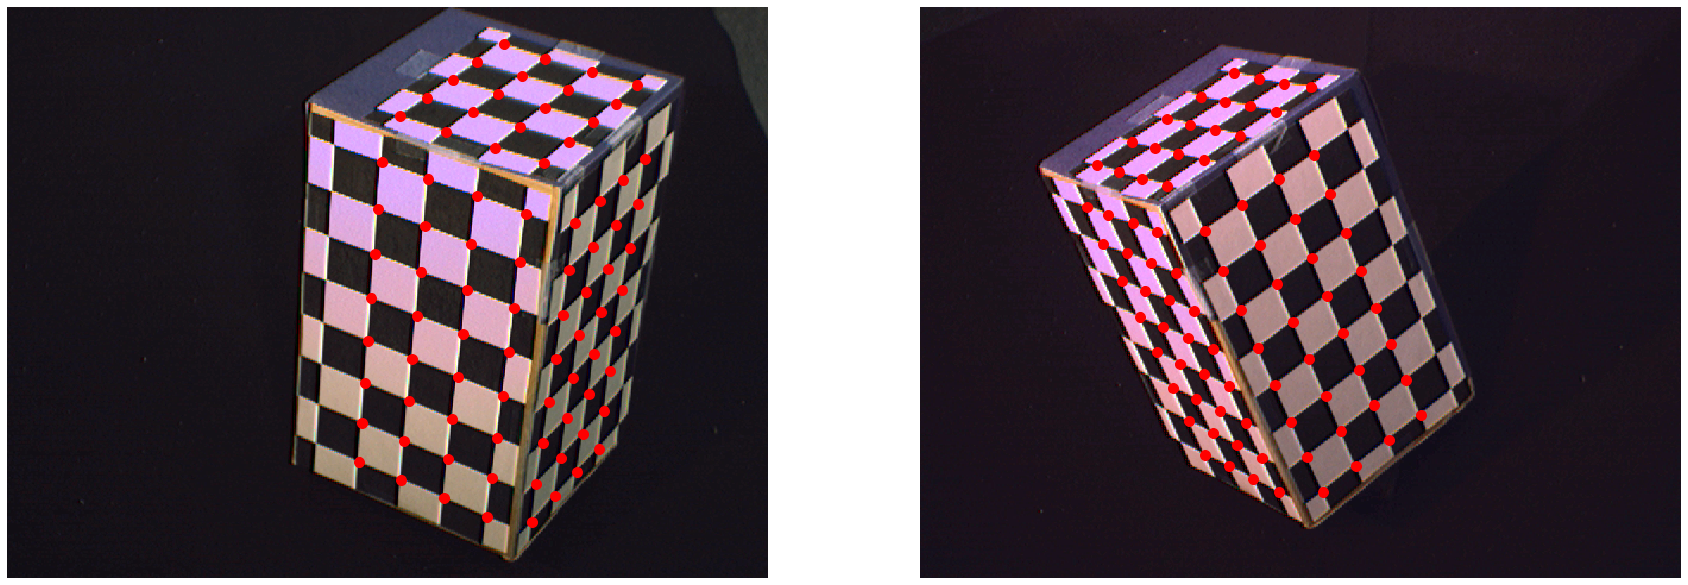

In [7]:
# Import pickle file and extract matrices

import pickle
data = pickle.load(open('./data/corners.pickle', 'rb'))

%matplotlib inline

leftpts = data['leftpts']
rightpts = data['rightpts']
corners_3D = data['corners_3D']

plt.rcParams['figure.figsize'] = [30, 30]
plt.subplot(1, 2, 1)
imgleft = cv2.cvtColor(cv2.imread('./data/calib_left.bmp'), cv2.COLOR_BGR2RGB)
plt.imshow(imgleft)
plt.plot(leftpts[:, 0], leftpts[:, 1], 'or', markersize=10)
plt.axis('off')
plt.subplot(1, 2, 2)
imgright = cv2.cvtColor(cv2.imread('./data/calib_right.bmp'), cv2.COLOR_BGR2RGB)
plt.imshow(imgright)
plt.plot(rightpts[:, 0], rightpts[:, 1], 'or', markersize=10)
plt.axis('off');

In [10]:
# Apply your getCamera function to estimate Pl and Pr below and print out the results:

Pl = getCamera(corners_3D, leftpts)
Pr = getCamera(corners_3D, rightpts)

print(Pl)
print(Pr)

[[-9.04591856e+00  3.66625698e+02  4.21828723e+01  2.39668696e+02]
 [-6.11904754e+02 -9.64555181e+00  2.85466445e+01  1.32272522e+02]
 [-9.62008343e-02  5.56579294e-02 -6.98012109e-02  5.61707439e-01]]
[[ 1.75292085e+02 -2.92067079e+02  7.68051517e+01 -1.50336793e+02]
 [ 5.22821656e+02  8.80777990e+01 -2.85270276e+01 -1.33078003e+02]
 [ 5.13270966e-02  5.75344753e-02  5.66242020e-02 -5.62983470e-01]]


/usr/share/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


**c.** To display the results, create a 3D plot showing the 3D points in <tt>corners.pickle</tt> along with a depiction of the position, orientation, and field of view of your two cameras. Store your camera matrices as variables named <tt>Pl</tt> and <tt>Pr</tt> in a <tt>.pickle</tt> file named <tt>StereoCameras.pickle</tt> (for use in Question 4) and include this file in your zip. See Hints and Information below.

**Some calculations.** To find the point along a certain back-projected line $\lambda P^+x + (1-\lambda)C$ that's distance $d$ from the camera center (note that I expressed the line in this way such that for $\lambda\in [0,1]$ we lie between $C$ and $P^+x$), we must have that $$d = dist(\lambda P^+x +(1-\lambda)C, C) = ||\lambda P^+x +(1-\lambda)C - C|| = ||\lambda P^+x - \lambda C||\implies \lambda = \frac{d}{||P^+x - C||}$$

In [11]:
# compute pseudo-inverses of camera matrices using 
# the numpy pseudoinverse function
Plinv = np.linalg.pinv(Pl)
Prinv = np.linalg.pinv(Pr)

# TEST
LL = np.dot(Plinv, np.concatenate([leftpts.transpose(), [np.ones(len(leftpts))]], axis=0))
LL = LL[:-1]/LL[-1]
LL = np.transpose(LL)
# print(LL[0])
# print(corners_3D[0])
# print(Cl)
# for i in range(len(corners_3D)):
#     print((Cl - corners_3D[i])/(Cl - LL[i]))


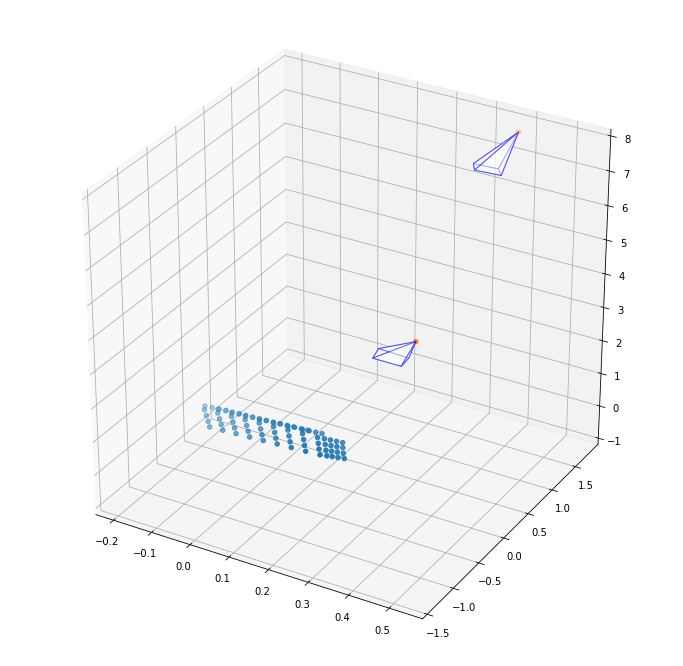

In [33]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 12]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


camera_mat = [Pl,Pr]
with open("./data/StereoCameras.pickle", "wb") as f:
    pickle.dump(camera_mat, f)
    f.close()

# Compute camera centers (null vectors of the camera matrices)
# as usual, we solve PC = 0 by SVD
# SVDs
Ul, Dl, Vl = np.linalg.svd(Pl)
Ur, Dr, Vr = np.linalg.svd(Pr)

# Dlmat = np.zeros((len(Ul[0]), len(Vl)))
# Dlmat[:len(Dl),:len(Dl)] = np.diag(Dl)
# print(np.allclose(Pl, np.dot(Ul, np.dot(Dlmat, Vl))))

# Extract last column of V matrices to get camera centers
Cl = Vl[-1,:]
Cr = Vr[-1,:]
# dehomogenize
Cl = Cl[:-1]/Cl[-1]
Cr = Cr[:-1]/Cr[-1]

# TODO: for now I am using this numpy function that computes the pseudo inverse but 
# eventually I should do it myself
Plinv = np.linalg.pinv(Pl)
Prinv = np.linalg.pinv(Pr)

d = 1
# back project image corners of left image
hl, wl = imgleft.shape[0], imgleft.shape[1]
cornersl = np.array([[0,0,1],[0,hl,1], [wl, hl,1], [wl, 0,1]]).transpose()
backprojl = np.dot(Plinv, cornersl)
backprojl = backprojl[:-1]/backprojl[-1]
backprojl = backprojl.transpose()
# ax.scatter(backprojl[:,0], backprojl[:,1], backprojl[:,2])

# back project right corners of the image
hr, wr = imgright.shape[0], imgright.shape[1]
cornersr = np.array([[0,0,1],[0,hr,1], [wr, hr,1], [wr, 0,1]]).transpose()
backprojr = np.dot(Prinv, cornersr)
backprojr = backprojr[:-1]/backprojr[-1]
backprojr = backprojr.transpose()


# now each row of backprojl is one of the backprojected corners in 
# inhomogeneous 3D coordinates, now I want to get each lambda
lambl = d / (np.sum(np.abs(backprojl - [Cl])**2, axis=-1)**(1./2))
cameraverticesl = [Cl] + np.transpose([lambl]) * (backprojl - [Cl])
cameraverticesl = np.concatenate([[Cl], cameraverticesl])
faces = [[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 1], [1,2,3,4]]
poly3dl = Poly3DCollection([[cameraverticesl[faces[i][j]] for j in range(len(faces[i]))] for i in range(len(faces))], 
                           facecolors='w', linewidths=1, alpha=0.5)
poly3dl.set_edgecolor('b')

# same for backprojr
lambr = d / (np.sum(np.abs(backprojr - [Cr])**2, axis=-1)**(1./2))
cameraverticesr = [Cr] + np.transpose([lambr]) * (backprojr - [Cr])
cameraverticesr = np.concatenate([[Cr], cameraverticesr])
poly3dr = Poly3DCollection([[cameraverticesr[faces[i][j]] for j in range(len(faces[i]))] for i in range(len(faces))], 
                           facecolors='w', linewidths=1, alpha=0.5)
poly3dr.set_edgecolor('b')


# making the axes nicer 
ax.set_zlim3d(-1,8)
# plot everything
ax.scatter(corners_3D[:,0], corners_3D[:,1], corners_3D[:,2])
ax.scatter([Cl[0], Cr[0]], [Cl[1], Cr[1]], [Cl[2], Cr[2]])
ax.add_collection3d(poly3dl)
ax.add_collection3d(poly3dr)


## Question 4 (25 points)

The images <tt>kleenex_left.bmp</tt> and <tt>kleenex_right.bmp</tt> comprise another
stereo pair captured by the same rig that was calibrated in Question 3. Here, you will use the calibration information obtained in that problem to reconstruct a 3D model of the Kleenex box.

**a.** When the two cameras in a stereo pair are calibrated and a left-right point match $\vx\leftrightarrow\vx'$ is given, the corresponding world point $\vX$ is recovered by back-projecting the rays through pixels $\vx$ and $\vx'$ and finding their point of intersection in 3-space.  This process is referred to as _triangulation_, and in the presence of noise, it can be solved using a linear algorithm.  The desired point $\vX$ must satisfy the equations $\vx=\mP\vX$ and $\vx'=\mP'\vX$, and these can equivalently be written as

$
\vx\times (\mP\vX)=0\ \ \mbox{and}\ \ \vx'\times (\mP'\vX)=0,
$

which are linear in the components of $\vX$.  Show that this system of equations can be written in the form $\mA\vX={\bf 0}$, with the elements of $\mA$ given explicitly in terms of $\vx$, $\vx'$, $\mP$ and $\mP'$.

**Proof.** By the chapter on DLT, we know that 
$$\textbf{x}\times \textbf{P}\textbf{X} = \begin{pmatrix}y\textbf{P}^{3T}\textbf{X} - w\textbf{P}^{2T}\textbf{X}\\
w\textbf{P}^{1T}\textbf{X} - x\textbf{P}^{3T}\textbf{X}\\
x\textbf{P}^{2T}\textbf{X} - y\textbf{P}^{1T}\textbf{X}\end{pmatrix} $$
Where $\textbf{x} = (x,y,z)$ and $\textbf{P}^{iT}$ is the $i$-th row of $\textbf{P}$. We can write this equivalently as
$$\textbf{x}\times\textbf{PX} = \underbrace{\begin{pmatrix}y\textbf{P}^{3T} - w\textbf{P}^{2T}\\
w\textbf{P}^{1T} - x\textbf{P}^{3T}\\
x\textbf{P}^{2T} - y\textbf{P}^{1T}\end{pmatrix}}_{M_1}\textbf{X} $$
where $y\textbf{P}^{3T} - w\textbf{P}^{2T}$ is the row vector given by $y$ times the $3$rd row of $\textbf{P}$ minus $w$ times the $2$nd row, and the other 2 rows of $M_1$ are defined similarly. Thus $\textbf{x}\times\textbf{PX}$ is equal to a $3\times 4$ matrix $M_1$ applied to $\textbf{X}$. 
Similarly, we have that
$$\textbf{x}'\times\textbf{P}'\textbf{X} = \underbrace{\begin{pmatrix}y'\textbf{P}'^{3T} - w'\textbf{P}'^{2T}\\
w'\textbf{P}'^{1T} - x'\textbf{P}'^{3T}\\
x'\textbf{P}'^{2T} - y'\textbf{P}'^{1T}\end{pmatrix}}_{M_2}\textbf{X}$$
where $\textbf{x}' = (x', y', z')$.
Now the condition that $M_1\textbf{X}$ and $M_2\textbf{X}$ simultaneously vanish is equivalent to the condition that 
$$\textbf{A}\textbf{X} = \begin{pmatrix}M_1\\\hline M_2\end{pmatrix}\textbf{X} $$
vanishes, where we've taken $\textbf{A}$ to be the $6\times 4$ matrix where we stack $M_1$ and $M_2$ above each other. Thus, we can write the system of equations as 
$\textbf{A}\textbf{X} = 0$.

But in fact $\textbf{A}$ can be made simpler! Note that the third rows of $M_1$ and of $M_2$ are not necessary to specify the problem, since the rows of $M_1$ and $M_2$ are linearly dependent. Then in fact in order to solve $\textbf{x}\times\textbf{PX} = 0$ and $\textbf{x}'\times\textbf{P}'\textbf{X} = 0$ simultaneously, we only need to simultaneously solve
$$\begin{pmatrix}y\textbf{P}^{3T} - w\textbf{P}^{2T}\\
w\textbf{P}^{1T} - x\textbf{P}^{3T}\end{pmatrix}\textbf{X} = 0 \text{   and   } \begin{pmatrix}y'\textbf{P}'^{3T} - w'\textbf{P}'^{2T}\\
w'\textbf{P}'^{1T} - x'\textbf{P}'^{3T}\end{pmatrix}\textbf{X} = 0$$
Which is equivalent to solving 
$$A\textbf{X} = \begin{pmatrix}
y\textbf{P}^{3T} - w\textbf{P}^{2T}\\
w\textbf{P}^{1T} - x\textbf{P}^{3T}\\
y'\textbf{P}'^{3T} - w'\textbf{P}'^{2T}\\
w'\textbf{P}'^{1T} - x'\textbf{P}'^{3T}
\end{pmatrix}\textbf{X} = 0$$
And this is a simpler expression for $\textbf{A}$!

**b.** Write a function <tt>triangulate(x1,x2,P1,P2) </tt> that takes camera matrices <tt> P1 </tt>, <tt> P2</tt> and image points <tt> x1</tt>, <tt> x2</tt> and estimates the 3D world point <tt> X</tt> by solving the homogeneous matrix equation developed in part (a). See the skeleton script.


In [13]:
def triangulate(x1, x2, P1, P2):
    # x1: point from left image in inhomogeneous coordinates
    # x2: point from right image in inhomogeneous coordinates
    # P1: left camera matrix
    # P2: right camera matrix
    
    # note that in this case w and w' are 1, since the 
    # points are given inhomogeneously
    A = np.concatenate([
        [x1[1] * P1[2] - P1[1]], 
        [P1[0] - x1[0] * P1[2]],
        [x2[1] * P2[2] - P2[1]], 
        [P2[0] - x2[0] * P2[2]]
    ])
    
    _, _, V = np.linalg.svd(A)
    
    X = V[-1,:]
    
    # return dehomogenized vector
    return X[:-1]/X[-1]

**b.** Manually identify the pixel coordinates of the seven visible corners of the Kleenex box in the images <tt> kleenex\_left.bmp</tt> and <tt> kleenex\_right.bmp</tt>.  For each of these seven correspondences $\vx_i\leftrightarrow\vx_i'$, use your function from part (b) along with the camera matrices <tt> Pl</tt> and <tt> Pr</tt> that you stored in <tt> StereoCameras.pickle</tt> to find the world coordinates of the corresponding 3D points through triangulation.  Estimate the position of the eighth (unseen) corner by assuming symmetry in the box. Create a 3D plot of a wireframe of the box along with the same graphical camera representations used in 3.

<IPython.core.display.Javascript object>


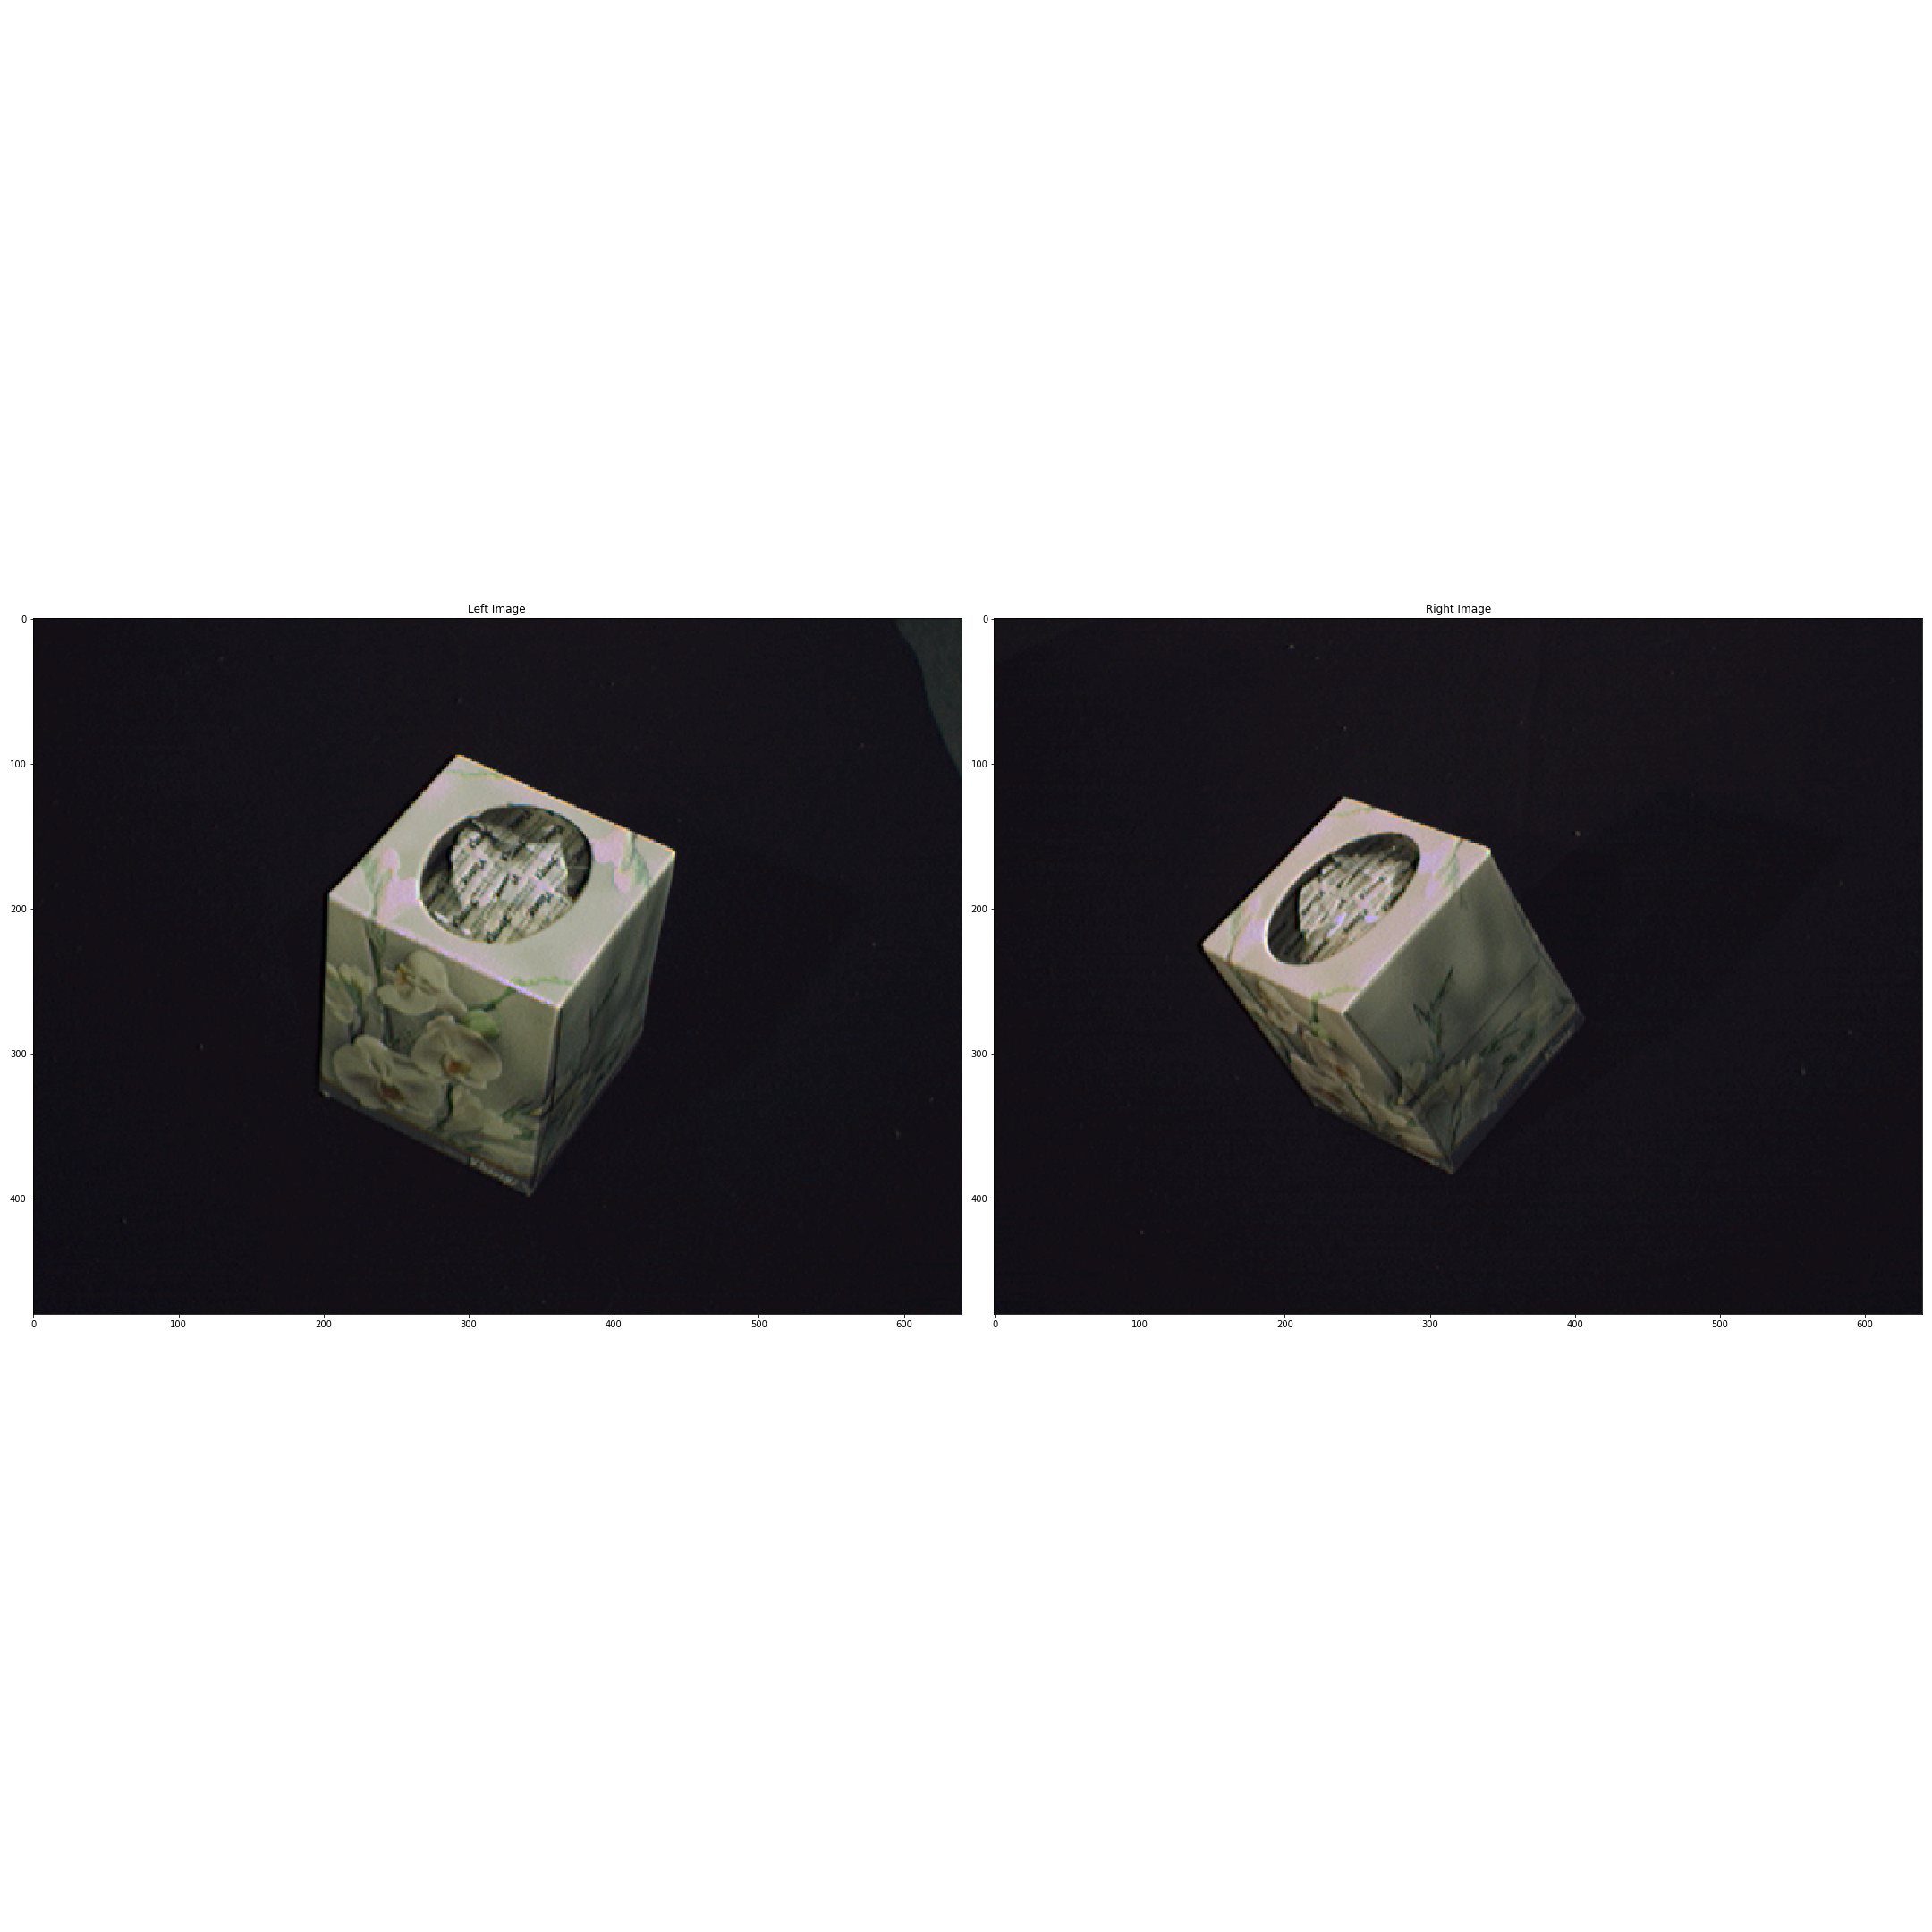

In [15]:
# Helper code for manually identifying pixel coordinates:

# First, load images:
im_left = cv2.cvtColor(cv2.imread('./data/kleenex_left.bmp'), cv2.COLOR_BGR2RGB)
im_right = cv2.cvtColor(cv2.imread('./data/kleenex_right.bmp'), cv2.COLOR_BGR2RGB)

%matplotlib notebook 

plt.figure()
plt.subplot(121)
plt.imshow(im_left)
plt.title('Left Image')
plt.subplot(122)
plt.imshow(im_right)
plt.title('Right Image')
plt.tight_layout()

# To identify correspondences, hover your cursor over each image 
# and record the numbers at the bottom right hand corner of the figure

# left and right points
xl = np.array([[204.825, 193.168], [293.400, 96.5818], [444.379, 164.986], 
              [361.843, 271.677], [198.786, 330.056], [341.713, 402.526], [422.235, 289.795]])
xr = np.array([[143.226, 229.403], [239.852, 126.738], [340.505, 162.973],
              [239.852, 275.704], [221.735, 342.134], [318.361, 386.421], [408.949, 279.730]])

# I will write the rest of the code for this part in a new box

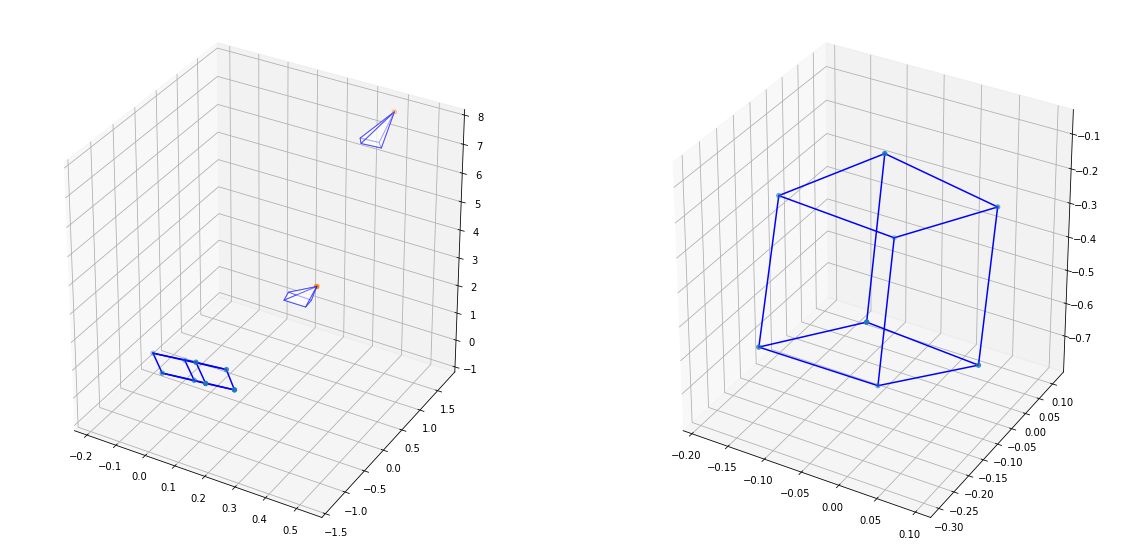

In [41]:
%matplotlib inline

# left and right points
xl = np.array([[204.825, 193.168], [293.400, 96.5818], [444.379, 164.986], 
              [361.843, 271.677], [198.786, 330.056], [341.713, 402.526], [422.235, 289.795]])
xr = np.array([[143.226, 229.403], [239.852, 126.738], [340.505, 162.973],
              [239.852, 275.704], [221.735, 342.134], [318.361, 386.421], [408.949, 279.730]])

with open("./data/StereoCameras.pickle", "rb") as f:
    Pl, Pr = pickle.load(f)
    
X = np.array([triangulate(xl[i], xr[i], Pl, Pr) for i in range(len(xl))])

# plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.figsize'] = [20, 10]
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ab = fig.add_subplot(122, projection='3d')

# ax.scatter(X[:,0], X[:,1], X[:,2])

# The points in X are ordered as top-left, top-up, top-right, top-down, bottom-left, bottom-down, bottom-right
# If this is a symmetric box, then the line between bottom-right and the missing point should be the same
# length and direction as the line between bottom-down and bottom-left
missing_pt = X[6] + (X[4] - X[5])
X = np.concatenate([X, [missing_pt]])

edges = [[0,1], [1,2], [2,3], [3,0], [0,4], [3, 5], [2,6], [1, 7], [4, 5], [5,6], [6,7], [7,4]]
for [a,b] in edges: 
    ax.plot3D(*zip(X[a], X[b]), color="b")
    ab.plot3D(*zip(X[a], X[b]), color="b")
ax.scatter(X[:,0], X[:,1], X[:,2])
ab.scatter(X[:,0], X[:,1], X[:,2])

# same cameras from before
# but for some reason I have to create this poly3dcollection object again
# or python gets angry at me
poly3dl = Poly3DCollection([[cameraverticesl[faces[i][j]] for j in range(len(faces[i]))] for i in range(len(faces))], 
                           facecolors='w', linewidths=1, alpha=0.5)
poly3dl.set_edgecolor('b')
poly3dr = Poly3DCollection([[cameraverticesr[faces[i][j]] for j in range(len(faces[i]))] for i in range(len(faces))], 
                           facecolors='w', linewidths=1, alpha=0.5)
poly3dr.set_edgecolor('b')

ax.set_zlim3d(-1,8)
ax.scatter([Cl[0], Cr[0]], [Cl[1], Cr[1]], [Cl[2], Cr[2]])

ax.add_collection3d(poly3dl)
ax.add_collection3d(poly3dr)

**c.** Given that the dimensions of each square in the checker board pattern used for calibration are 2cm$\times$2cm, estimate the volume of the kleenex box.

In [17]:
# two consecutive points are 2cm apart in the real world
# we want to know how far they are in our 3D coordinates
X0, X1 = corners_3D[0], corners_3D[1]
print(np.linalg.norm(X0-X1))

# measurements of width, height, depth of kleenex box
width = np.linalg.norm(X[5]-X[4])
depth = np.linalg.norm(X[6]-X[5])
height = depth = np.linalg.norm(X[3]-X[5])
print("Width, depth, height of kleenex box in 3d coordinates:")
print(width, depth, height)
print("Width, depth, height of kleenex box in real-world centimeters:")
print(width * 2 / np.linalg.norm(X0-X1), depth * 2 / np.linalg.norm(X0-X1), height * 2 / np.linalg.norm(X0-X1))
print(width * depth * height * 8 / ((np.linalg.norm(X0-X1))**3))

0.04697796725781534
Width, depth, height of kleenex box in 3d coordinates:
0.3183139467920788 0.2813229592762236 0.2813229592762236
Width, depth, height of kleenex box in real-world centimeters:
13.551627087020183 11.976804263680531 11.976804263680531
1943.897432631286


### Answer:
By the bit of code I wrote above, we have that a distance of $0.04697796725781534$ in our 3D coordinate system translates into a distance of 2cm in the real world. We measured the width, depth, and height of the kleenex box in our 3D coordinate system to be 
0.3183139467920788, 0.2813229592762236, 0.2813229592762236 respectively. Thus the width, depth, and height in centimeters are obtained by multiplying the measurements in coordinates by $\frac{2}{0.04697796725781534}$, so they are $13.551627087020183cm, 11.976804263680531cm,$ and $11.976804263680531cm$ respectively. The volume is then
$$Vol = (13.551627087020183cm)(11.976804263680531cm)(11.976804263680531cm) = 1943.897432631286cm^3$$

## Bonus Question 5 (10 points)

Exploit the fact that the box is polygonal and symmetric to obtain a complete 3D model using the eight points recovered in Prob 4. The box consists of six planar facets $\Pi_k,\ k=1\ldots 6$, and for each facet, there are necessarily homographies between it (as a world plane) and each of the two image planes of the stereo rig.  By estimating these homographies, the texture for each (visible) facet can be extracted from the images and "mapped on" to a 3D model. Create a 3D model with texture taken from the images and mapped onto each facet. (Unobserved facets can be hallucinated by assuming symmetry.) The result can be displayed using repeated calls to the <tt> plot_surface </tt> command as described in the hints and and information.

In [20]:
# code from last pset
# I've removed all comments to make it shorter
def DLT(x1, x2):
    X1 = np.transpose(np.concatenate([np.transpose(x1), [np.ones(len(x1))]]))
    X2 = np.transpose(np.concatenate([np.transpose(x2), [np.ones(len(x2))]]))
    A = np.concatenate(
    [np.concatenate(
        [[np.concatenate([np.zeros(3), -X1[i], X2[i][1]*X1[i]])],
         [np.concatenate([X1[i], np.zeros(3), -X2[i][0]*X1[i]])]
        ]) for i in range(len(X1))], axis=0)
    _, _, V = np.linalg.svd(A)
    h = V[-1,:]
    return h.reshape(3,3)

def getH(X1, X2):
    T1 = getT(X1)    
    X1n = T1.dot(np.concatenate([X1.transpose(), np.ones((1, len(X1)), dtype=np.float32)], axis=0)).transpose()
    X1ni = X1n[:, :2] / X1n[:, 2:]
    T2 = getT(X2)
    X2n = T2.dot(np.concatenate([X2.transpose(), np.ones((1, len(X2)), dtype=np.float32)], axis=0)).transpose()
    X2ni = X2n[:, :2] / X2n[:, 2:]
    HH = DLT(X1ni, X2ni)
    H = np.linalg.lstsq(T2, np.dot(HH, T1))[0]
    return H

def applyH(Iin, H, xmin = None, ymin = None, xmax = None, ymax = None):
    h, w = Iin.shape[0], Iin.shape[1]
    corners = np.concatenate([np.array([[0.],[0.],[1.]]), 
                              np.array([[0.],[h - 1.],[1.]]), 
                              np.array([[w - 1.], [0.],[1.]]), 
                              np.array([[w - 1.], [h - 1.],[1.]])], axis=1)
    newcorners = np.dot(H, corners)
#     xmin = (np.amin(newcorners[0]/newcorners[2]) if xmin != None else xmin)
#     xmax = (np.amax(newcorners[0]/newcorners[2]) if xmax != None else xmax)
#     ymin = (np.amin(newcorners[1]/newcorners[2]) if ymin != None else ymin)
#     ymax = (np.amax(newcorners[1]/newcorners[2]) if ymax != None else ymax)
    num_x_points = w
    num_y_points = h
    x, y = np.meshgrid(np.linspace(xmin, xmax, num_x_points), np.linspace(ymin, ymax, num_y_points))
    X = np.stack([x.flatten(), y.flatten()])
    xh = np.linalg.lstsq(H, np.concatenate([X, [np.ones(len(X[0]))]]))[0]
    Xh = xh[:2] / xh[2]
    interpolator = scipy.interpolate.RegularGridInterpolator((np.arange(num_y_points), np.arange(num_x_points)), 
                                                             Iin, bounds_error=False, 
                                                             fill_value=np.nan)
    Iout = interpolator(np.transpose(np.array([Xh[1], Xh[0]])))
    Iout = np.reshape(Iout, (num_y_points, num_x_points))
    Iout[Iout == np.nan] = 0
    return Iout

In [21]:
%matplotlib inline

# Rectify the faces of the kleenex box 

# The points in X are ordered as top-left, top-up, 
# top-right, top-down, bottom-left, bottom-down, bottom-right, unseen point
# I can get the coordinates of the corners of each face in the "face plane" by just
# setting one of the corners to (0,0) and measuring the width and height of the face
# I'm going to do this one by one which is super janky because I don't know a better way
# label face clockwise starting from top-left

left = [0,3,5,4]
right = [3,2,6,5]
top = [0,1,2,3]
backright = [2,1,7,6]
backleft = [1,0,4,7]
bottom = [5,4,7,6]
faces = [left, right, top, backright, backleft, bottom]
facescoords = []
for face in faces:
    facescoords.append([[0,0], [np.linalg.norm(X[face[1]]-X[face[0]]),0], 
                       [np.linalg.norm(X[face[1]]-X[face[0]]), np.linalg.norm(X[face[2]]-X[face[0]])], 
                       [0,np.linalg.norm(X[face[2]]-X[face[0]])]])
# use left kleenex image
H = getH(np.array([xl[0],xl[3], xl[5], xl[4]]), np.array(facescoords[0]))
# im_left_red   = im_left[:, :, 0]
# im_left_blue  = im_left[:, :, 2]
# im_left_green = im_left[:, :, 1]
# nr, ng, nb = applyH(im_left_red, H), applyH(im_left_green, H), applyH(im_left_blue, H)
# iout = np.array([zip(nr[i], ng[i], nb[i]) for i in range(len(nr))])
im_left = cv2.imread('./data/kleenex_left.bmp')
im_left_blue, im_left_green, im_left_red = cv2.split(im_left)

# make each of the unseen faces the same as the opposite one 
outims_blue = [applyH(im_left_blue,
                 getH(np.array([xl[faces[i % 3][0]], xl[faces[i % 3][1]], xl[faces[i % 3][2]], xl[faces[i % 3][3]]]), np.array(facescoords[i % 3])), 
                 facescoords[i % 3][0][0], 
                 facescoords[i % 3][0][1], 
                 facescoords[i % 3][2][0], 
                 facescoords[i % 3][2][1]) for i in range(len(facescoords))]
outims_red = [applyH(im_left_red,
                 getH(np.array([xl[faces[i % 3][0]], xl[faces[i % 3][1]], xl[faces[i % 3][2]], xl[faces[i % 3][3]]]), np.array(facescoords[i % 3])), 
                 facescoords[i % 3][0][0], 
                 facescoords[i % 3][0][1], 
                 facescoords[i % 3][2][0], 
                 facescoords[i % 3][2][1]) for i in range(len(facescoords))]
outims_green = [applyH(im_left_green,
                 getH(np.array([xl[faces[i % 3][0]], xl[faces[i % 3][1]], xl[faces[i % 3][2]], xl[faces[i % 3][3]]]), np.array(facescoords[i % 3])), 
                 facescoords[i % 3][0][0], 
                 facescoords[i % 3][0][1], 
                 facescoords[i % 3][2][0], 
                 facescoords[i % 3][2][1]) for i in range(len(facescoords))]
print(outims_red[0])
i=0
# print(cv2.merge((outims_red[i], outims_green[i], outims_blue[i])))

outims = []
for i in range(len(outims_blue)):
    outims.append(cv2.merge((outims_red[i], outims_green[i], outims_blue[i])))
# outims = [cv2.merge((outims_red[i], outims_green[i], outims_blue[i])) for i in range(len(outims_blue))]
# print(outims)


/usr/share/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/share/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


[[142.3422     152.6606677  158.4912015  ... 128.13303434 116.89809314
  105.969555  ]
 [145.76784446 156.80644647 161.36537235 ... 126.22050037 115.33071179
  104.74721756]
 [149.08804904 161.09845755 162.70887795 ... 124.08113272 112.70203851
  100.89363813]
 ...
 [ 18.98720109  22.40285408  24.54995431 ...  17.98679845  17.36691818
   16.63132242]
 [ 21.95317117  26.56646819  28.23088327 ...  18.09809954  17.42214871
   16.74618266]
 [ 23.82376     26.48102537  25.08804935 ...  18.21266179  17.53683851
   16.861     ]]


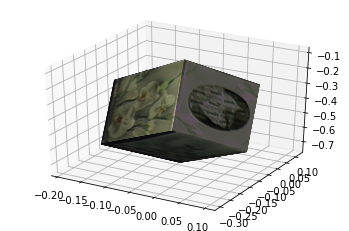

In [23]:
# Overlay the images on your box:
plt.figure()
ax = plt.axes(projection='3d')

for i in range(len(outims)):
    x,y = np.meshgrid(np.linspace(0, 1, outims[i].shape[1]+1), np.linspace(0, 1, outims[i].shape[0]+1))
    face = np.array([X[faces[i][0]],
                 X[faces[i][1]],
                 X[faces[i][3]],
                 X[faces[i][2]]])
    points = [face[0, i] * (1-x) * (1-y) + face[1, i] * x * (1 - y) +
          face[2, i] * (1-x) * y +     face[3, i] * x * y for i in range(3)]  
    ax.plot_surface(*points, rstride=5, cstride=5, facecolors=(outims[i] / 255.0))


## Hints and Information

.pickle files are data containers used by Python. A .pickle file may include matrices, arrays, scalars or even functions. To save some variables in current workspace into a .pickle file, use the following
  command

```python
camera_mat = [Pl,Pr]
with open("./data/camera_matrices.pickle", "wb") as f:
    pickle.dump(camera_mat, f)
    f.close()
```

This will create a <tt> filename.pickle</tt> file in your current directory, which can be loaded later (say when you exit and reopen jupyterhub next time).The loading command is
  
```python
with open("./data/camera_matrices.pickle", "rb") as f:
    camera_matrices = pickle.load(f)
```

This will dump the variables you saved last time (<tt> var1, var2 </tt>, ...) into the current workspace.

A convenient graphical representation for a camera is a pentahedron.  One vertex of the five-sided polygon is placed at the camera center, and the other four vertices are found by back-projecting rays through the four corners of the image and placing a point along each ray at a fixed distance $d$ from the camera center. When these vertices are connected, the camera looks like a pyramid, and it's position, orientation, and field of view can all be readily observed.

Recovering the camera center and other useful information from a camera matrix is discussed in Sect. 6.2 of HZ. This is an important section to read. In python, a polygon can be drawn as a wireframe using the <tt> plot_wireframe </tt> command or as a solid using the <tt> PolyCollection </tt> command.
    
In Python the <tt> plot_surface </tt> command can be used to draw a rectangular facet with an image texture-mapped onto it. This is done by setting the <tt>facecolors </tt> property of the surface to a color or grayscale image array. Consult the online documentation for matplotlib <tt> plot_surface </tt> for more information. 

The following code loads an image and texture-maps it onto a rectangular facet with top-left corner $(0,1,0)$ and bottom-right corner $(1,0,0)$.

```python
kleenex_left = np.float32(cv2.imread('./data/kleenex_left.bmp')) / 255.0
kleenex_left = cv2.cvtColor(kleenex_left, cv2.COLOR_BGR2RGB)

x, y = np.meshgrid(np.linspace(0, 1, kleenex_left.shape[1]+1), np.linspace(0, 1, kleenex_left.shape[0]+1))


face = np.array([[0,1,0],
                 [1,1,0],
                 [0,0,0],
                 [1,0,0]])
points = [face[0, i] * (1-x) * (1-y) + face[1, i] * x * (1 - y) +
          face[2, i] * (1-x) * y +     face[3, i] * x * y for i in range(3)]

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(*points, rstride=5, cstride=5, facecolors=kleenex_left)
```

# Tests

In [ ]:
# Test
# LL = np.dot(Pl, np.concatenate([corners_3D.transpose(), [np.ones(len(corners_3D))]], axis=0))
# LL = LL[:-1]/LL[-1]
# LL = np.transpose(LL)
# print(LL)
# print(leftpts)

# im_left = cv2.imread('./data/kleenex_left.bmp')
# im_left_blue, im_left_green, im_left_red = cv2.split(im_left)
# im_left = cv2.merge((im_left_red, im_left_green, im_left_blue))
# plt.imshow(im_left)